In [1]:
# data analysis and wrangling
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
%matplotlib inline

# machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import classification_report

#preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Metrics Libraries
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



In [2]:
dfRaw = pd.read_csv('./Data/Input.csv', delimiter = ',', nrows = 6000000)


# Encode categorical columns
df = dfRaw.copy()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Convert everything to float
df = df.astype(float)


dfRaw.head(5)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
#Checking for balance in target
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=df['isFraud'].value_counts())])
fig.show()

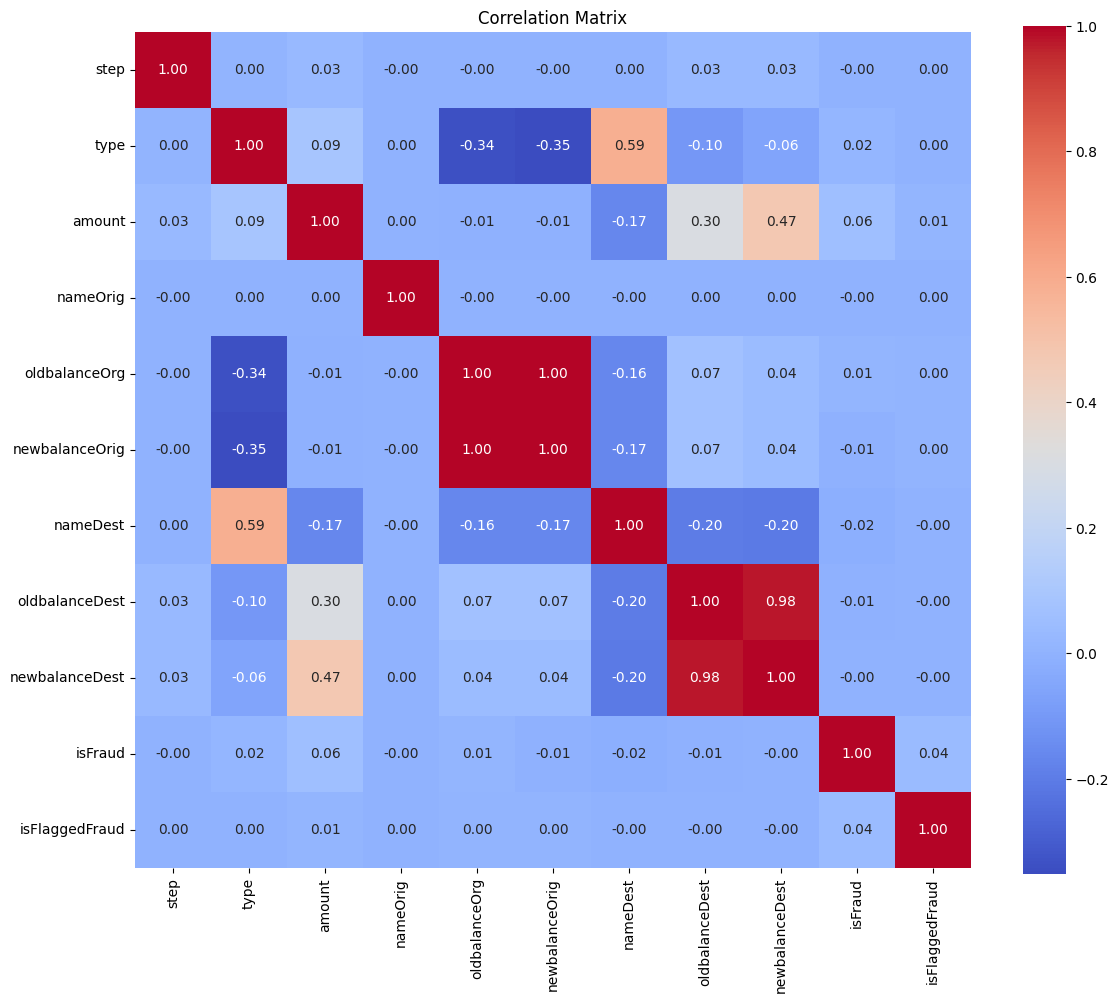

isFraud           1.000000
amount            0.058469
isFlaggedFraud    0.035286
type              0.016459
oldbalanceOrg     0.007135
newbalanceDest   -0.000057
nameOrig         -0.000196
step             -0.002458
oldbalanceDest   -0.005144
newbalanceOrig   -0.006849
nameDest         -0.017131
Name: isFraud, dtype: float64


In [4]:
plt.figure(figsize=(12, 10))

# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

target_corr = corr_matrix['isFraud'].sort_values(ascending=False)
print(target_corr)

In [5]:
#preprocessing

#drop 'isFraud' from X
X = df.drop('isFraud', axis=1)
y = df['isFraud']

#split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)


In [6]:
#feature engineering (maybe Ill remove the type and newbalance columns later)

#df['balanceDiffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balanceDiffDest'] = df['newbalanceDest'] - df['oldbalanceDest']


In [7]:
# Scaling for unsupervised learning

df_sample = df.sample(100000, random_state=42)

X_scaled = df_sample.drop(columns=['isFraud'])

def Standard_Scaler(df):
    scaler = StandardScaler()
    
    # Fit on data and transform
    df[col_names] = scaler.fit_transform(df[col_names])
    
    return df

col_names = ['type', 'amount', 'step', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
X_scaled = Standard_Scaler(X_scaled)

X_scaled.head(5)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,balanceDiffDest
1324896,-0.731627,-0.526298,0.032045,1417514.0,-0.288090,-0.291962,485752.0,-0.028780,-0.006242,0.0,200935.59
3566176,0.304283,0.956482,-0.153347,1386453.0,-0.288090,-0.291962,1268415.0,-0.320267,-0.326044,0.0,0.00
1109043,-0.790582,1.697872,3.140970,3702181.0,-0.216675,-0.291962,250908.0,-0.068025,0.486853,0.0,2173297.67
4286042,0.700119,-1.267688,-0.067015,5658741.0,6.357182,6.319670,417860.0,-0.255361,-0.303861,0.0,-138090.29
5395174,1.289662,-0.526298,0.022703,3262906.0,-0.275661,-0.291962,279855.0,0.181574,0.184073,0.0,195008.79


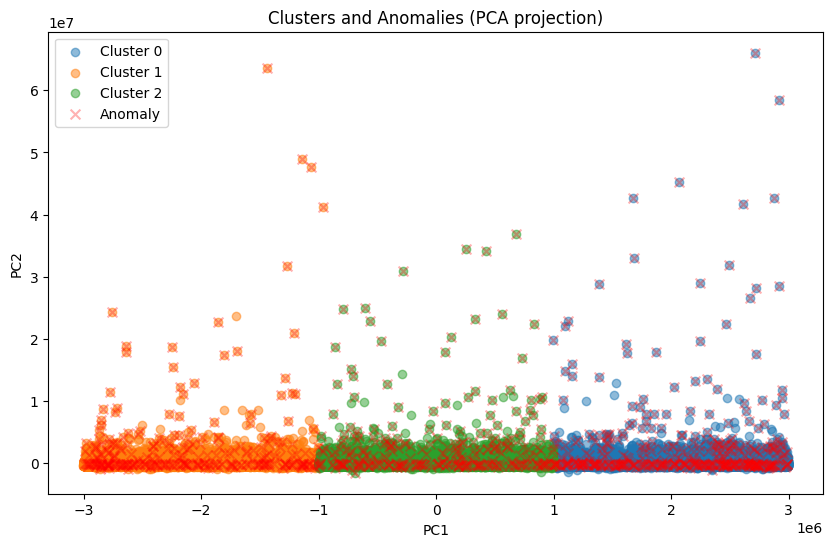

                          PC1           PC2
step            -2.184351e-10  7.465513e-09
type             1.763746e-09  6.868859e-08
amount           4.242950e-09  9.713886e-07
nameOrig         9.999899e-01 -4.305371e-03
oldbalanceOrg    8.916107e-10 -6.210473e-08
newbalanceOrig   7.968759e-10 -6.791155e-08
nameDest         3.634411e-04 -2.044932e-01
oldbalanceDest  -2.625748e-11  3.357419e-07
newbalanceDest   1.175832e-09  5.687796e-07
isFlaggedFraud  -0.000000e+00  0.000000e+00
balanceDiffDest  4.474241e-03  9.788585e-01
cluster         -2.222710e-07 -1.019015e-09


In [22]:
# Unsupervised Learning with KMEans and Isolation Forest
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

iso = IsolationForest(contamination=0.01, random_state=42)
df_sample['anomaly'] = (iso.fit_predict(X_scaled) == -1).astype(int)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_sample['cluster'] = clusters

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Use cluster color and anomaly shape
plt.figure(figsize=(10, 6))
for cluster_id in sorted(df_sample['cluster'].unique()):
    cluster_mask = df_sample['cluster'] == cluster_id
    plt.scatter(
        X_pca[cluster_mask, 0],
        X_pca[cluster_mask, 1],
        label=f'Cluster {cluster_id}',
        alpha=0.5
    )

# Overlay anomalies (red X markers)
anomalies = df_sample['anomaly'] == 1
plt.scatter(
    X_pca[anomalies, 0],
    X_pca[anomalies, 1],
    color='red', marker='x', label='Anomaly', s=50, alpha=0.3
)

plt.title("Clusters and Anomalies (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

df_show = df_sample.copy()

df_show.groupby('cluster').mean(numeric_only=True)

df_show['PC1'] = X_pca[:, 0]
df_show['PC2'] = X_pca[:, 1]

df_show['anomaly'] = iso.fit_predict(X_scaled)
df_show['anomaly'] = df_show['anomaly'].map({1: 0, -1: 1})

df_show[df_show['anomaly'] == 1].sort_values(by='PC2', ascending=False).head(5)


loadings = pd.DataFrame(pca.components_.T, index=X_scaled.columns, columns=['PC1', 'PC2'])
print(loadings)

In [16]:
# Making sets for supervised learning, using the feature importances and the new cluster column

X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

X.to_numpy()
y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)

# Determine the importance of each feature
#model_xgb = xgb.XGBClassifier(random_state=42)
#model_xgb.fit(X_train, y_train)
#
## Set the figure size before plotting
#plt.figure(figsize=(14, 8))
#xgb.plot_importance(model_xgb, importance_type='weight', max_num_features=12, title='Feature Importances')
#plt.show()

X.head(5)

KeyboardInterrupt: 

In [10]:
#training without sampling

from sklearn.metrics import average_precision_score, precision_recall_curve


kf = StratifiedKFold(n_splits=5, shuffle=True)

model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=99.9/1,
    tree_method='hist',
    device = 'cuda',
    eval_metric='logloss',
    #predictor='gpu_predictor',
    random_state=42
)

model.fit(X_train, y_train)
y_scores = model.predict_proba(X_test)[:, 1]
Y_pred = (y_scores >= 0.8105).astype(int)
#rf.score(X_train, y_train)

scoreAcc = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
scoreRe = cross_val_score(model, X_train, y_train, cv=kf, scoring='recall')

cm = confusion_matrix(y_test, Y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

xgb.plot_importance(model, importance_type='gain')

print("Random Forest Classifier Accuracy: {}".format(scoreAcc))
print("Cross Validation Recall scores are: {}".format(scoreRe))
print("Average Cross Validation Recall score: {}".format(scoreRe.mean()))
print(classification_report(y_test, Y_pred))

[06:12:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



KeyboardInterrupt: 

In [ ]:
#training with SMOTE (with optimal parameters)

from imblearn.over_sampling import SMOTE

kf = StratifiedKFold(n_splits=5, shuffle=True)

pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=13)),
    ('model', xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    #scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    tree_method='hist',
    device = 'cuda',
    eval_metric='aucpr',
    random_state=42,
    subsample=0.8,
    #colsample_bytree=0.8
    ))
])
#the weights should be around 1:6-1:7
#rf = RandomForestClassifier(n_estimators=1000, random_state=13, max_depth=10, class_weight={0: 1, 1: 6})
#rf.fit(X_train_resampled, y_train_resampled)

pipeline.fit(X_train, y_train)
#y_scores = pipeline.predict_proba(X_test)[:, 1]
#Y_pred = (y_scores >= 0.9837).astype(int)
#rf.score(X_train, y_train)
Y_pred = pipeline.predict(X_test)

scoreAcc = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='accuracy')
scoreRe = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='recall')

cm = confusion_matrix(y_test, Y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Random Forest Classifier Accuracy: {}".format(scoreAcc))
print("Cross Validation Recall scores are: {}".format(scoreRe))
print("Average Cross Validation Recall score: {}".format(scoreRe.mean()))
print(classification_report(y_test, Y_pred, target_names=["Not Fraud", "Fraud"]))

f:\ComputerStuff\Anaconda\envs\tf_env\lib\site-packages\xgboost\core.py:158: UserWarning:

[23:40:37] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\context.cc:196: XGBoost is not compiled with CUDA support.



KeyboardInterrupt: 

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=  11.4s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=  11.4s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=  11.2s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=  11.2s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=  11.2s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, model__subsample=1; total time=  10.7s
[CV] END model__colsample_bytree

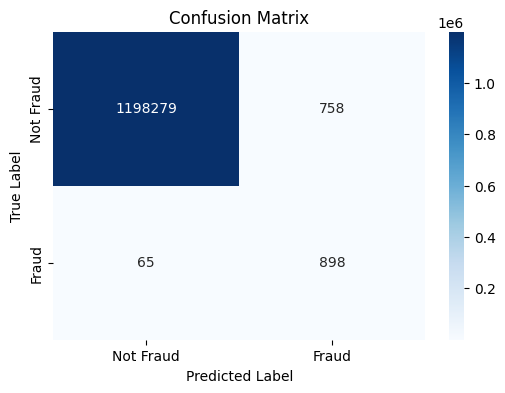

Random Forest Classifier Accuracy: [0.98905625 0.98970625 0.98923542 0.98911667 0.98888333]
Cross Validation Recall scores are: [0.98571429 0.98701299 0.99090909 0.9844358  0.99610895]
Average Cross Validation Recall score: 0.9888362221436152
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00   1199037
       Fraud       0.54      0.93      0.69       963

    accuracy                           1.00   1200000
   macro avg       0.77      0.97      0.84   1200000
weighted avg       1.00      1.00      1.00   1200000



In [ ]:
# Hyperparameter grid to optimize recall
'''
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV


pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=13)),
    ('model', xgb.XGBClassifier(
    tree_method='hist',
    device = 'cuda',
    eval_metric='aucpr',
    random_state=42
    ))
])

param_grid = {
    'model__n_estimators': [100, 300, 500, 1000],
    'model__max_depth': [3, 6, 10, 12],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.3],
    'model__subsample': [0.8, 1],
    'model__colsample_bytree': [0.8, 1],
}

f1 = make_scorer(f1_score)

grid_search = GridSearchCV(pipeline, param_grid, scoring='recall', cv=kf, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best params:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)
# Best parameters found: {'class_weight': {0: 1, 1: 10}, 'max_depth': 10, 'n_estimators': 500} n can be more
# Dont use this for now, it takes too long to run, so only run as one cell
# for the new one Best 
# params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 6, 'model__n_estimators': 500, 'model__subsample': 0.8}
# Best F1 score: 0.9888362221436152


best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

scoreAcc = cross_val_score(best_rf, X_train, y_train, cv=kf, scoring='accuracy')
scoreRe = cross_val_score(best_rf, X_train, y_train, cv=kf, scoring='recall')

cm = confusion_matrix(y_test, Y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Random Forest Classifier Accuracy: {}".format(scoreAcc))
print("Cross Validation Recall scores are: {}".format(scoreRe))
print("Average Cross Validation Recall score: {}".format(scoreRe.mean()))
print(classification_report(y_test, Y_pred, target_names=["Not Fraud", "Fraud"]))
'''

In [ ]:
#Usage of recall curve to get optimal treshold

import numpy as np
from sklearn.metrics import average_precision_score, precision_recall_curve


kf = StratifiedKFold(n_splits=5, shuffle=False)

#model = xgb.XGBClassifier(
#    n_estimators=500,
#    max_depth=10,
#    learning_rate=0.1,
#    scale_pos_weight=99/1,
#    tree_method='hist',
#    device = 'cuda',
#    eval_metric='logloss',
#    random_state=42
#)

pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=13)),
    ('model', xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=10,
    learning_rate=0.01,
    #scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    tree_method='hist',
    device = 'cuda',
    eval_metric='aucpr',
    random_state=42,
    #subsample=0.8,
    #colsample_bytree=0.8
    ))
])

pipeline.fit(X_train, y_train)
Y_pred = pipeline.predict(X_test)
#rf.score(X_train, y_train)

y_scores = pipeline.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
combined_scores = 0.5 * f1_scores + 0.5 * recalls

best_index = np.argmax(combined_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

print(f"Best F1 score: {best_f1:.4f} at threshold: {best_threshold:.4f}")
print(f"F1 score: {f1_scores[best_index]:.4f}")
print(f"Recall: {recalls[best_index]:.4f}")

Best F1 score: 0.8476 at threshold: 0.9837
F1 score: 0.8476
Recall: 0.8463
